In [1]:
#pip install lifelines

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from lifelines.utils import to_long_format
import matplotlib.pyplot as plt
import sys
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

In [3]:
# Enter ip address and port number of the system where the database resides.
server = '20.198.58.32' 
database = 'INT77DB2014'  
username = 'boadmin' 
password = 'BoAdmin12#$'

In [4]:
# Add appropriate driver name
import pyodbc
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [5]:
query = '''select distinct clntnum,
c.cltsex,
rtrim(c.GIVNAME)+' '+rtrim(c.SURNAME) client_name,
c.marryd,
occpcode,
upper(c.CLTADDR05) clientregion,
case when (select count(1) from 
vm1dta.ustfpf u,vm1dta.chdrpf pol 
where pol.CHDRNUM=u.chdrnum and pol.COWNNUM=c.clntnum and pol.VALIDFLAG=1) >0 
then 1 else 0 end marketbased, --market product identified based on transactions in ustfpf
case when entry_age between 0 and 20 then 'young age'
when entry_age between 21 and 50 then 'working age group' 
when entry_age between 51 and 60 then 'old age' 
when entry_age > 60 then 'retired group'
end entry_age, --entry age used instead of current age
case when (select count(1) from vm1dta.chdrpf pol 
where pol.VALIDFLAG=1 and pol.STATCODE ='IF' and pol.COWNNUM = c.clntnum and pol.CURRTO=99999999) > 0 then 0 else 1 end 
churn,
case when amtpaid >= 0 and amtpaid <= 100000 then 'low value' 
when amtpaid >= 100001 and amtpaid <= 1000000 then 'medium value' 
when  amtpaid > 1000001 then 'high value' 
end amtpaid,
case when (select datediff(day,cast(cast(min(occdate) as varchar(8)) as date),getdate()) from vm1dta.chdrpf pol where pol.COWNNUM = c.CLNTNUM and pol.VALIDFLAG=1) <0 then 10 
else  (select datediff(day,cast(cast(min(occdate) as varchar(8)) as date),getdate()) from vm1dta.chdrpf pol where pol.COWNNUM = c.CLNTNUM and pol.VALIDFLAG=1) end elapseddays
from vm1dta.clntpf c,
(select min(ANBCCD) entry_age,COWNNUM
from vm1dta.lifepf l,vm1dta.chdrpf pol  where l.chdrnum=pol.chdrnum and life='01' and l.VALIDFLAG=1 and pol.VALIDFLAG
=1 and l.lifcnum=pol.COWNNUM group by COWNNUM) age_band,
(select c.cownnum,sum(acctamt) amtpaid from vm1dta.rtrnpf r,vm1dta.chdrpf c 
where r.rldgacct=c.chdrnum and rtrim(r.sacscode)='LP' and rtrim(r.sacstyp)='S' and c.validflag=1 and r.BATCTRCDE='B522'
group by c.cownnum) total_paid
where validflag=1
and C.CLNTNUM = age_band.COWNNUM
and c.CLNTNUM = total_paid.COWNNUM
and c.cltdod = 99999999 --condition for death'''


In [6]:
# inputDf stores the data from the above query 
inputDf = pd.read_sql(query,cnxn)

In [7]:
#getting premiums and cost as a separate dataset for each customer
query1 = '''select clntnum,premium,isnull(claimpaid,0),(premium-isnull(claimpaid,0)) net_profit
from(
select distinct clntnum,premium,
(select sum(TOTAMNT) from vm1dta.regppf p ,vm1dta.chdrpf pol where p.CHDRNUM 

=pol.chdrnum  and c.validflag=1 and pol.VALIDFLAG
=1 and pol.COWNNUM = c.CLNTNUM) claimpaid
from vm1dta.clntpf c,
(select c.cownnum,sum(acctamt) premium from vm1dta.rtrnpf r,vm1dta.chdrpf c 
where r.rldgacct=c.chdrnum and rtrim(r.sacscode)='LP' and rtrim(r.sacstyp)='S' and 

c.validflag=1 and r.BATCTRCDE='B522'
group by c.cownnum) total_paid
where CLTTYPE='P' and CLTIND ='C' and validflag=1
and c.CLNTNUM = total_paid.COWNNUM)t'''

In [8]:
# Read data
premiumDf = pd.read_sql(query1,cnxn)

# Close the cursor
cursor.close() 

In [9]:
inputDf.head()

,clntnum,cltsex,client_name,marryd,occpcode,clientregion,marketbased,entry_age,churn,amtpaid,elapseddays
0,0001828,M,Raj Mathur,M,,...,1,working age group,0,high value,3771
1,0001888,M,Ram Singh,S,,...,1,working age group,0,low value,1945
2,0001906,M,Scott Fritz,M,ANYS,...,1,working age group,0,low value,119
3,0001908,M,Personal Personal one,M,ANYS,...,1,working age group,0,medium value,119
4,0002012,M,Angelino Antonio,M,ACON,...,0,working age group,0,low value,2634


In [10]:
inputDf.shape

(729, 11)

In [11]:
inputDf.columns

Index(['clntnum', 'cltsex', 'client_name', 'marryd', 'occpcode',
       'clientregion', 'marketbased', 'entry_age', 'churn', 'amtpaid',
       'elapseddays'],
      dtype='object')

In [12]:
inputDf['marryd'].unique()

array(['M', 'S', ' ', 'Z', 'D', 'C', None], dtype=object)

In [13]:
premiumDf.head()

,clntnum,premium,,net_profit
0,0001529,117589.00,0.0,117589.00
1,0001588,43957.24,3744.5,40212.74
2,0001611,388195.38,0.0,388195.38
3,0001645,462155.18,0.0,462155.18
4,0001649,102460.96,0.0,102460.96


In [14]:
premiumDf.shape

(1258, 4)

In [15]:
#data set for coordinates , to be mapped to client region for now
regionDf=pd.read_csv("coordinates.csv")
regionDf.drop('region_code',inplace=True,axis=1)
regionDf['clientregion']=[name.upper().strip(' ') for name in regionDf.province]

inputDf['clientregion']=[name.upper().strip(' ') for name in inputDf.clientregion]

In [16]:
#model will not require the customer number, but would be required to merge with output
modelDf=inputDf.drop('clntnum',axis=1)
modelDf.drop('client_name',inplace=True,axis=1)
#modelDf=modelDf.merge(regionDf,how='left',on='clientregion')
modelDf.occpcode.fillna('ANYS',inplace=True)
modelDf.amtpaid.fillna('medium value',inplace=True)
modelDf.marryd.fillna('medium value',inplace=True)
modelDf.drop('clientregion',inplace=True,axis=1)
'''modelDf.drop('province',inplace=True,axis=1)
modelDf.drop('latitude',inplace=True,axis=1)
modelDf.drop('longitude',inplace=True,axis=1)'''

inputDfCoordinates=inputDf.merge(regionDf,how='left',on='clientregion')

In [17]:
lb=LabelEncoder()

In [18]:
modelDf['cltsex']=lb.fit_transform(modelDf['cltsex'])
modelDf['marryd']=lb.fit_transform(modelDf['marryd'])
modelDf['occpcode']=lb.fit_transform(modelDf['occpcode'])
modelDf['amtpaid']=lb.fit_transform(modelDf['amtpaid'])
modelDf['entry_age']=lb.fit_transform(modelDf['entry_age'])
#modelDf.latitude.fillna(value=0,inplace=True)
#modelDf.longitude.fillna(value=0,inplace=True)
#modelDf.head(100)

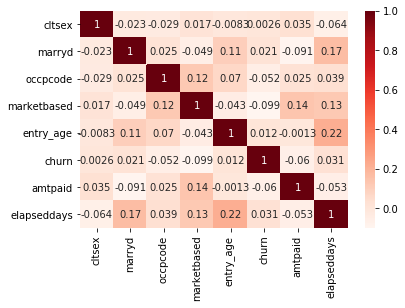

In [19]:
#to find the correlation between features
corr=modelDf.corr()
sns.heatmap(corr,annot=True,cmap=plt.cm.Reds)

#plt.show()

In [20]:
cor_target = abs(corr["churn"])
print(cor_target)
relevant_features = cor_target[cor_target>0.1]
print(relevant_features)

cltsex         0.002605
marryd         0.021429
occpcode       0.051592
marketbased    0.099243
entry_age      0.012343
churn          1.000000
amtpaid        0.059758
elapseddays    0.031108
Name: churn, dtype: float64
churn    1.0
Name: churn, dtype: float64


In [21]:
cph = CoxPHFitter()
print('output from show progress')
print('///////////////////////////////////')
cph.fit(modelDf, duration_col='elapseddays', event_col='churn',show_progress=True,step_size=0.1)
print('//////////////////////////////////')
cph.print_summary()

output from show progress
///////////////////////////////////
Iteration 1: norm_delta = 0.67181, step_size = 0.1000, log_lik = -148.63186, newton_decrement = 6.42456, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.62403, step_size = 0.1000, log_lik = -147.41042, newton_decrement = 5.43825, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.58550, step_size = 0.1000, log_lik = -146.37636, newton_decrement = 4.64180, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.54916, step_size = 0.1200, log_lik = -145.32782, newton_decrement = 3.87038, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.51838, step_size = 0.1440, log_lik = -144.29121, newton_decrement = 3.14659, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.49934, step_size = 0.1728, log_lik = -143.29423, newton_decrement = 2.49354, seconds_since_start = 0.0
Iteration 7: norm_delta = 0.50384, step_size = 0.2074, log_lik = -142.36193, newton_decrement = 1.93413, seconds_since_start = 0.0
Iteration 8: norm_del

Iteration 87: norm_delta = 1.71404, step_size = 0.0412, log_lik = -137.40957, newton_decrement = 0.00104, seconds_since_start = 0.5
Iteration 88: norm_delta = 1.71405, step_size = 0.0404, log_lik = -137.40948, newton_decrement = 0.00100, seconds_since_start = 0.5
Iteration 89: norm_delta = 1.71405, step_size = 0.0396, log_lik = -137.40941, newton_decrement = 0.00096, seconds_since_start = 0.5
Iteration 90: norm_delta = 1.71405, step_size = 0.0388, log_lik = -137.40933, newton_decrement = 0.00092, seconds_since_start = 0.5
Iteration 91: norm_delta = 1.71406, step_size = 0.0380, log_lik = -137.40926, newton_decrement = 0.00089, seconds_since_start = 0.5
Iteration 92: norm_delta = 1.71406, step_size = 0.0372, log_lik = -137.40920, newton_decrement = 0.00086, seconds_since_start = 0.5
Iteration 93: norm_delta = 1.71406, step_size = 0.0365, log_lik = -137.40914, newton_decrement = 0.00083, seconds_since_start = 0.5
Iteration 94: norm_delta = 1.71406, step_size = 0.0358, log_lik = -137.40908

Iteration 162: norm_delta = 1.71412, step_size = 0.0091, log_lik = -137.40792, newton_decrement = 0.00022, seconds_since_start = 0.9
Iteration 163: norm_delta = 1.71412, step_size = 0.0089, log_lik = -137.40791, newton_decrement = 0.00021, seconds_since_start = 0.9
Iteration 164: norm_delta = 1.71412, step_size = 0.0087, log_lik = -137.40791, newton_decrement = 0.00021, seconds_since_start = 0.9
Iteration 165: norm_delta = 1.71412, step_size = 0.0085, log_lik = -137.40791, newton_decrement = 0.00021, seconds_since_start = 0.9
Iteration 166: norm_delta = 1.71412, step_size = 0.0083, log_lik = -137.40790, newton_decrement = 0.00021, seconds_since_start = 0.9
Iteration 167: norm_delta = 1.71412, step_size = 0.0082, log_lik = -137.40790, newton_decrement = 0.00021, seconds_since_start = 0.9
Iteration 168: norm_delta = 1.71412, step_size = 0.0080, log_lik = -137.40790, newton_decrement = 0.00020, seconds_since_start = 0.9
Iteration 169: norm_delta = 1.71412, step_size = 0.0079, log_lik = -1

Iteration 243: norm_delta = 1.71412, step_size = 0.0018, log_lik = -137.40779, newton_decrement = 0.00015, seconds_since_start = 1.3
Iteration 244: norm_delta = 1.71412, step_size = 0.0017, log_lik = -137.40779, newton_decrement = 0.00015, seconds_since_start = 1.3
Iteration 245: norm_delta = 1.71412, step_size = 0.0017, log_lik = -137.40779, newton_decrement = 0.00015, seconds_since_start = 1.3
Iteration 246: norm_delta = 1.71412, step_size = 0.0017, log_lik = -137.40779, newton_decrement = 0.00015, seconds_since_start = 1.3
Iteration 247: norm_delta = 1.71412, step_size = 0.0016, log_lik = -137.40779, newton_decrement = 0.00015, seconds_since_start = 1.3
Iteration 248: norm_delta = 1.71412, step_size = 0.0016, log_lik = -137.40779, newton_decrement = 0.00015, seconds_since_start = 1.3
Iteration 249: norm_delta = 1.71412, step_size = 0.0016, log_lik = -137.40779, newton_decrement = 0.00015, seconds_since_start = 1.3
Iteration 250: norm_delta = 1.71412, step_size = 0.0015, log_lik = -1

//////////////////////////////////


C:\Users\aaacharya\AppData\Local\Continuum\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1110: ConvergenceWarning: Column occpcode have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['churn'].astype(bool)
>>> print(df.loc[events, 'occpcode'].var())
>>> print(df.loc[~events, 'occpcode'].var())

A very low variance means that the column occpcode completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\aaacharya\AppData\Local\Continuum\anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:702: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 1.714. This may imply non-unique solutions to the maximum lik

In [22]:
#cph.plot()

In [23]:
cph.check_assumptions(modelDf,show_plots=True)

Proportional hazard assumption looks okay.


In [24]:
#survival function only required for censored subjects,ie. customers who have not churned yet. 
notChurnedCustomers= modelDf[modelDf['churn']==0]
censoredTimeElapse=notChurnedCustomers.elapseddays

In [25]:
values=modelDf.entry_age.unique()
#cph.plot_covariate_groups('entry_age', values=values,cmap='coolwarm')

In [26]:
#to be computed for 5 years to extract all type of policies that fall under 5 yrs renewal term
results=cph.predict_survival_function(notChurnedCustomers,times=[365,730,1095,1460,1825],conditional_after=censoredTimeElapse)

In [27]:
outputDf=results.transpose().merge(modelDf,how='right',left_index=True,right_index=True)
outputDf['clntnum']=inputDf['clntnum']


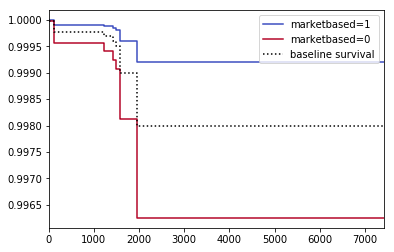

In [28]:
values=modelDf.marketbased.unique()
cph.plot_covariate_groups('marketbased', values=values,cmap='coolwarm')

In [29]:
cltvDf=outputDf.merge(premiumDf,on='clntnum')

In [30]:
#Calculate the LTV
cltvDf['cltvscore']=((cltvDf['net_profit']*cltvDf[365])/(1+0.12))+((cltvDf['net_profit']*cltvDf[730])/(1+0.11)**2)+((cltvDf['net_profit']*cltvDf[1095])/(1+0.1)**3)+((cltvDf['net_profit']*cltvDf[1460])/(1+0.09)**4)+((cltvDf['net_profit']*cltvDf[1825])/(1+0.08)**5)
+(cltvDf['net_profit']/(cltvDf['elapseddays']/365))*(cltvDf['elapseddays']/365)

0      1.631795e+06
1      6.504480e+04
2      3.652268e+04
3      1.079188e+05
4     -1.099999e+08
5      9.020480e+03
6      6.988800e+03
7      8.022880e+03
8      7.305536e+04
9      4.981760e+03
10     5.165000e+02
11     1.262350e+03
12     2.813440e+04
13     1.109602e+05
14     3.765440e+03
15     1.080986e+06
16    -4.809987e+04
17     1.871430e+05
18     1.424196e+04
19     1.864681e+05
20     4.034688e+04
21     1.168384e+04
22     3.548317e+04
23     1.544000e+03
24     2.186688e+04
25    -1.564755e+07
26     3.419525e+05
27     4.682000e+03
28     5.206982e+04
29     7.209440e+03
           ...     
698    1.480000e+05
699    1.636000e+03
700    9.002540e+04
701    7.944268e+04
702    1.990803e+04
703    2.806000e+05
704    4.977884e+04
705    3.179366e+05
706    6.100000e+03
707    1.780800e+04
708    4.880000e+04
709    4.161920e+03
710    1.322827e+04
711    3.770000e+04
712    7.061376e+04
713    7.490000e+04
714    3.513859e+04
715    7.152157e+04
716    1.044960e+04


In [31]:
#LTV percentile
cltvDf['percentile']=cltvDf['cltvscore'].rank(pct=True,method='max')*100

In [32]:
#Function for Customer bifurcation into Low, Medium and High value based upon LTV percentile.
def cltvBandFn(percentile):
    if (percentile >= 0 and percentile < 30):
        return 'low value'
    else:
        if (percentile > 30 and percentile < 60):
            return 'medium value'
        else:
            return 'high value'

In [33]:
#Apply cltvband function and merge
cltvDf['cltvband']=cltvDf.percentile.apply(cltvBandFn)
csvDf=cltvDf.merge(inputDfCoordinates[['client_name','cltsex','marryd','occpcode','latitude','longitude']],right_index=True,left_index=True)

In [34]:
csvDf.to_csv("EX_SOURCE_CLTVSCORE_LIFE.csv",index=False)
